***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.3)** 64D>32D>16D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "2" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  2
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('4_CIFAR_100/HD_CapsNet/Mod_3_3')

FOLDER CREATED =  ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_3


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 32
    SCap_c_dims = 64


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims),
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Skip Connection: For Medium Level
    p_caps_m = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_c.shape[-1]),
                                     s_caps_c.shape[-1]), name="primary_skip_m")(p_caps)
    skip_m = keras.layers.Concatenate(axis=1)([p_caps_m, s_caps_c])

    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(skip_m)
    
    ## Skip Connection: For Fine Level
    p_caps_f = keras.layers.Reshape((int((tf.reduce_prod(p_caps.shape[1:]).numpy())/s_caps_m.shape[-1]),
                                     s_caps_m.shape[-1]), name="primary_skip_f")(p_caps)
    skip_f = keras.layers.Concatenate(axis=1)([p_caps_f, s_caps_m])

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(skip_f)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 20)          0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 100)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)                                                                                              
          

 )                                                                                                
                                                                                                  
 tf.math.square_2 (TFOpLambda)  (None, 20)           0           ['tf.math.maximum_2[0][0]']      
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 20)          0           ['tf.math.subtract_9[0][0]']     
 a)                                                                                               
                                                                                                  
 tf.math.square_3 (TFOpLambda)  (None, 20)           0           ['tf.math.maximum_3[0][0]']      
                                                                                                  
 tf.math.reduce_sum_3 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)      

 )                                                                                                
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]',               
 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 8)           0           ['tf.math.multiply_7[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_7 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.4316 - prediction_coarse_accuracy: 0.4792 - prediction_medium_accuracy: 0.2694 - prediction_fine_accuracy: 0.0917
  • Coarse Accuracy = 47.92% | Val_Accuracy = 56.64% | LossWeight = 0.37 
  • Medium Accuracy = 26.94% | Val_Accuracy = 36.57% | LossWeight = 0.47 
  • Fine   Accuracy = 9.17% | Val_Accuracy = 16.26% | LossWeight = 0.15 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.16260, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 215s 252ms/step - loss: 0.4316 - prediction_coarse_accuracy: 0.4792 - prediction_medium_accuracy: 0.2694 - prediction_fine_accuracy: 0.0917 - val_loss: 0.3684 - val_prediction_coarse_accuracy: 0.5664 - val_prediction_medium_accuracy: 0.3657 - val_prediction_fine_accuracy: 0.1626 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3192 - prediction_coarse_accuracy: 0.6156

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1160 - prediction_coarse_accuracy: 0.9161 - prediction_medium_accuracy: 0.8753 - prediction_fine_accuracy: 0.6939
  • Coarse Accuracy = 91.61% | Val_Accuracy = 83.89% | LossWeight = 0.31 
  • Medium Accuracy = 87.53% | Val_Accuracy = 73.96% | LossWeight = 0.42 
  • Fine   Accuracy = 69.39% | Val_Accuracy = 59.29% | LossWeight = 0.27 

Epoch 18: val_prediction_fine_accuracy did not improve from 0.59590
781/781 [==============================] - 198s 253ms/step - loss: 0.1160 - prediction_coarse_accuracy: 0.9161 - prediction_medium_accuracy: 0.8753 - prediction_fine_accuracy: 0.6939 - val_loss: 0.1349 - val_prediction_coarse_accuracy: 0.8389 - val_prediction_medium_accuracy: 0.7396 - val_prediction_fine_accuracy: 0.5929 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1136 - prediction_coarse_accuracy: 0.9181 - prediction_medium_accuracy: 0.8803 - prediction_fine_accuracy: 

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.0964 - prediction_coarse_accuracy: 0.9415 - prediction_medium_accuracy: 0.9192 - prediction_fine_accuracy: 0.7754
  • Coarse Accuracy = 94.15% | Val_Accuracy = 85.03% | LossWeight = 0.32 
  • Medium Accuracy = 91.92% | Val_Accuracy = 76.12% | LossWeight = 0.40 
  • Fine   Accuracy = 77.54% | Val_Accuracy = 62.27% | LossWeight = 0.29 

Epoch 27: val_prediction_fine_accuracy improved from 0.62010 to 0.62270, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 194s 248ms/step - loss: 0.0964 - prediction_coarse_accuracy: 0.9415 - prediction_medium_accuracy: 0.9192 - prediction_fine_accuracy: 0.7754 - val_loss: 0.1275 - val_prediction_coarse_accuracy: 0.8503 - val_prediction_medium_accuracy: 0.7612 - val_prediction_fine_accuracy: 0.6227 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0949 - prediction_coarse_accur

781/781 [==============================] - ETA: 0s - loss: 0.0848 - prediction_coarse_accuracy: 0.9538 - prediction_medium_accuracy: 0.9404 - prediction_fine_accuracy: 0.8505
  • Coarse Accuracy = 95.38% | Val_Accuracy = 85.65% | LossWeight = 0.34 
  • Medium Accuracy = 94.04% | Val_Accuracy = 77.15% | LossWeight = 0.40 
  • Fine   Accuracy = 85.05% | Val_Accuracy = 63.93% | LossWeight = 0.26 

Epoch 45: val_prediction_fine_accuracy did not improve from 0.64490
781/781 [==============================] - 203s 260ms/step - loss: 0.0848 - prediction_coarse_accuracy: 0.9538 - prediction_medium_accuracy: 0.9404 - prediction_fine_accuracy: 0.8505 - val_loss: 0.1247 - val_prediction_coarse_accuracy: 0.8565 - val_prediction_medium_accuracy: 0.7715 - val_prediction_fine_accuracy: 0.6393 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0839 - prediction_coarse_accuracy: 0.9551 - prediction_medium_accuracy: 0.9423 - prediction_fine_accuracy: 0.8556
  • Co

781/781 [==============================] - 163s 209ms/step - loss: 0.0833 - prediction_coarse_accuracy: 0.9560 - prediction_medium_accuracy: 0.9445 - prediction_fine_accuracy: 0.8689 - val_loss: 0.1239 - val_prediction_coarse_accuracy: 0.8605 - val_prediction_medium_accuracy: 0.7783 - val_prediction_fine_accuracy: 0.6461 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0830 - prediction_coarse_accuracy: 0.9563 - prediction_medium_accuracy: 0.9451 - prediction_fine_accuracy: 0.8716
  • Coarse Accuracy = 95.63% | Val_Accuracy = 86.17% | LossWeight = 0.36 
  • Medium Accuracy = 94.51% | Val_Accuracy = 77.86% | LossWeight = 0.40 
  • Fine   Accuracy = 87.16% | Val_Accuracy = 64.77% | LossWeight = 0.24 

Epoch 55: val_prediction_fine_accuracy improved from 0.64690 to 0.64770, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 166s 212ms/step - loss: 0.0830 - prediction_coarse_accuracy: 

Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0821 - prediction_coarse_accuracy: 0.9572 - prediction_medium_accuracy: 0.9461 - prediction_fine_accuracy: 0.8810
  • Coarse Accuracy = 95.72% | Val_Accuracy = 86.34% | LossWeight = 0.36 
  • Medium Accuracy = 94.61% | Val_Accuracy = 77.97% | LossWeight = 0.41 
  • Fine   Accuracy = 88.10% | Val_Accuracy = 65.16% | LossWeight = 0.23 

Epoch 64: val_prediction_fine_accuracy improved from 0.65100 to 0.65160, saving model to ../../logs/4_CIFAR_100/HD_CapsNet/Mod_3_3\epoch-best.h5
781/781 [==============================] - 162s 208ms/step - loss: 0.0821 - prediction_coarse_accuracy: 0.9572 - prediction_medium_accuracy: 0.9461 - prediction_fine_accuracy: 0.8810 - val_loss: 0.1229 - val_prediction_coarse_accuracy: 0.8634 - val_prediction_medium_accuracy: 0.7797 - val_prediction_fine_accuracy: 0.6516 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0832 - prediction_coarse_accur

781/781 [==============================] - 167s 214ms/step - loss: 0.0810 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9466 - prediction_fine_accuracy: 0.8905 - val_loss: 0.1217 - val_prediction_coarse_accuracy: 0.8643 - val_prediction_medium_accuracy: 0.7815 - val_prediction_fine_accuracy: 0.6541 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0814 - prediction_coarse_accuracy: 0.9574 - prediction_medium_accuracy: 0.9461 - prediction_fine_accuracy: 0.8905
  • Coarse Accuracy = 95.74% | Val_Accuracy = 86.48% | LossWeight = 0.37 
  • Medium Accuracy = 94.61% | Val_Accuracy = 78.22% | LossWeight = 0.42 
  • Fine   Accuracy = 89.05% | Val_Accuracy = 65.47% | LossWeight = 0.22 

Epoch 83: val_prediction_fine_accuracy did not improve from 0.65470
781/781 [==============================] - 163s 209ms/step - loss: 0.0814 - prediction_coarse_accuracy: 0.9574 - prediction_medium_accuracy: 0.9461 - prediction_fine_accuracy: 0.890

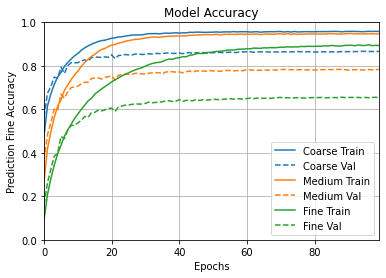

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

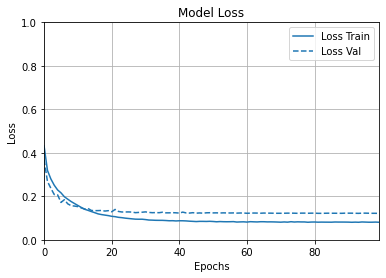

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 14s 35ms/step - loss: 0.1658 - prediction_coarse_loss: 0.0998 - prediction_medium_loss: 0.1673 - prediction_fine_loss: 0.2745 - prediction_coarse_accuracy: 0.8663 - prediction_medium_accuracy: 0.7843 - prediction_fine_accuracy: 0.6549
1. loss ==> 0.1657860279083252
2. prediction_coarse_loss ==> 0.09976255148649216
3. prediction_medium_loss ==> 0.1673388034105301
4. prediction_fine_loss ==> 0.2744663953781128
5. prediction_coarse_accuracy ==> 0.8662999868392944
6. prediction_medium_accuracy ==> 0.7843000292778015
7. prediction_fine_accuracy ==> 0.6549000144004822
313/313 [==============================] - 10s 28ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

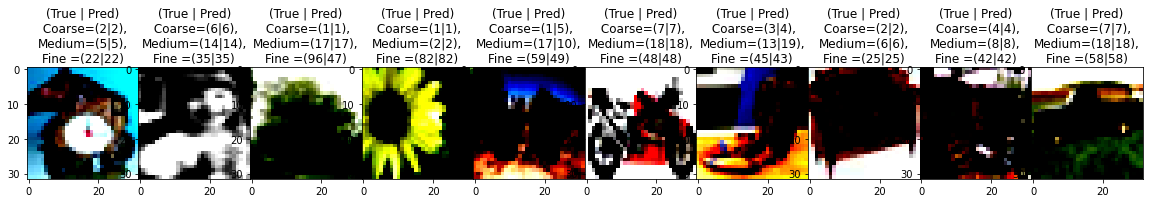

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 721   11   16   27  194   11   10   10]
 [   7 1357   27   37   43   23    1    5]
 [  12   21 1363   21   29   11   20   23]
 [  16   29   29  799  111    7    4    5]
 [ 105   23   43   91 2196   12   10   20]
 [   7   30   22    4   24  887    0   26]
 [   7   10   15    9   25    1  428    5]
 [   6    0   31   10   21   20    0  912]]

  • MEDIUM LEVEL 
[[322  28   0   0   0   5   2   3  15   1   3  12  27  13   4  32  28   0
    1   4]
 [ 27 374   6   5   6   5   1   4   5   3   4   2   4  11   8  16  11   0
    3   5]
 [  0   4 442   4  17   3   2  19   2   1   1   0   1   2   0   1   1   0
    0   0]
 [  0   1   4 421  12  24   7   2   2   3   0   0   2   5   5   4   0   0
    1   7]
 [  0   3  18   7 427   6   0   5   7   1   0   1   2  12   1   4   2   2
    2   0]
 [  0   4   0  31   5 391  21   1   2   3   1   4   1   9  10   3   0   2
    6   6]
 [  1   8   0  12   2  17 427   1   1   4   2   0   1   4   8   2   1   1
    5   3]


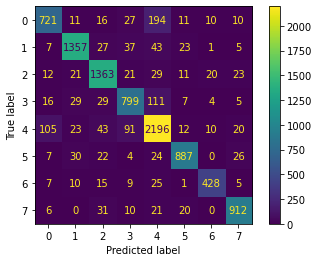

              precision    recall  f1-score   support

           0    0.81839   0.72100   0.76661      1000
           1    0.91627   0.90467   0.91043      1500
           2    0.88163   0.90867   0.89494      1500
           3    0.80060   0.79900   0.79980      1000
           4    0.83087   0.87840   0.85398      2500
           5    0.91255   0.88700   0.89959      1000
           6    0.90486   0.85600   0.87975       500
           7    0.90656   0.91200   0.90927      1000

    accuracy                        0.86630     10000
   macro avg    0.87147   0.85834   0.86430     10000
weighted avg    0.86646   0.86630   0.86582     10000


  • MEDIUM LEVEL 


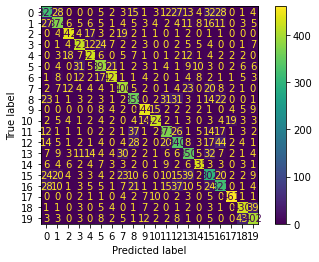

              precision    recall  f1-score   support

           0    0.68220   0.64400   0.66255       500
           1    0.76639   0.74800   0.75709       500
           2    0.87873   0.88400   0.88136       500
           3    0.81274   0.84200   0.82711       500
           4    0.84554   0.85400   0.84975       500
           5    0.76667   0.78200   0.77426       500
           6    0.87860   0.85400   0.86613       500
           7    0.77519   0.80000   0.78740       500
           8    0.70949   0.71800   0.71372       500
           9    0.86381   0.88800   0.87574       500
          10    0.90021   0.84800   0.87333       500
          11    0.76025   0.74200   0.75101       500
          12    0.66277   0.68000   0.67127       500
          13    0.69034   0.70000   0.69513       500
          14    0.88057   0.87000   0.87525       500
          15    0.59802   0.60400   0.60100       500
          16    0.65510   0.64200   0.64848       500
          17    0.92570   0

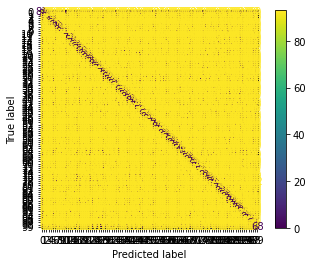

              precision    recall  f1-score   support

           0    0.84375   0.81000   0.82653       100
           1    0.80000   0.80000   0.80000       100
           2    0.50000   0.51000   0.50495       100
           3    0.55263   0.42000   0.47727       100
           4    0.54023   0.47000   0.50267       100
           5    0.59459   0.66000   0.62559       100
           6    0.75000   0.69000   0.71875       100
           7    0.70707   0.70000   0.70352       100
           8    0.83505   0.81000   0.82234       100
           9    0.80808   0.80000   0.80402       100
          10    0.50549   0.46000   0.48168       100
          11    0.44211   0.42000   0.43077       100
          12    0.76238   0.77000   0.76617       100
          13    0.56190   0.59000   0.57561       100
          14    0.65741   0.71000   0.68269       100
          15    0.62037   0.67000   0.64423       100
          16    0.65049   0.67000   0.66010       100
          17    0.84615   0

In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7673683333333332 
Hierarchical Recall = 0.7868666666666666 
Hierarchical F1-Score = 0.7750503968253968 
Consistency =  0.8832 
Exact Match =  0.6258


# Training Again

In [23]:
model_save_dir = str(directory+'/trained_model_2.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.1173 - prediction_coarse_accuracy: 0.9156 - prediction_medium_accuracy: 0.8782 - prediction_fine_accuracy: 0.7726
  • Coarse Accuracy = 91.56% | Val_Accuracy = 80.93% | LossWeight = 0.34 
  • Medium Accuracy = 87.82% | Val_Accuracy = 71.64% | LossWeight = 0.44 
  • Fine   Accuracy = 77.26% | Val_Accuracy = 57.99% | LossWeight = 0.21 

Epoch 1: val_prediction_fine_accuracy did not improve from 0.65600
781/781 [==============================] - 147s 188ms/step - loss: 0.1173 - prediction_coarse_accuracy: 0.9156 - prediction_medium_accuracy: 0.8782 - prediction_fine_accuracy: 0.7726 - val_loss: 0.1619 - val_prediction_coarse_accuracy: 0.8093 - val_prediction_medium_accuracy: 0.7164 - val_prediction_fine_accuracy: 0.5799 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1114 - prediction_coarse_accuracy: 0.9193 - prediction_medium_accuracy: 0.8867 - prediction_fine_accuracy: 0.7759


Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0998 - prediction_coarse_accuracy: 0.9349 - prediction_medium_accuracy: 0.9132 - prediction_fine_accuracy: 0.8135
  • Coarse Accuracy = 93.49% | Val_Accuracy = 84.13% | LossWeight = 0.35 
  • Medium Accuracy = 91.32% | Val_Accuracy = 75.44% | LossWeight = 0.42 
  • Fine   Accuracy = 81.35% | Val_Accuracy = 61.31% | LossWeight = 0.23 

Epoch 10: val_prediction_fine_accuracy did not improve from 0.65600
781/781 [==============================] - 146s 188ms/step - loss: 0.0998 - prediction_coarse_accuracy: 0.9349 - prediction_medium_accuracy: 0.9132 - prediction_fine_accuracy: 0.8135 - val_loss: 0.1360 - val_prediction_coarse_accuracy: 0.8413 - val_prediction_medium_accuracy: 0.7544 - val_prediction_fine_accuracy: 0.6131 - lr: 0.0010
Epoch 11/100
781/781 [==============================] - ETA: 0s - loss: 0.0970 - prediction_coarse_accuracy: 0.9412 - prediction_medium_accuracy: 0.9204 - prediction_fine_accuracy: 0.82

781/781 [==============================] - 144s 184ms/step - loss: 0.0886 - prediction_coarse_accuracy: 0.9490 - prediction_medium_accuracy: 0.9342 - prediction_fine_accuracy: 0.8646 - val_loss: 0.1311 - val_prediction_coarse_accuracy: 0.8520 - val_prediction_medium_accuracy: 0.7658 - val_prediction_fine_accuracy: 0.6383 - lr: 6.3025e-04
Epoch 20/100
781/781 [==============================] - ETA: 0s - loss: 0.0880 - prediction_coarse_accuracy: 0.9506 - prediction_medium_accuracy: 0.9358 - prediction_fine_accuracy: 0.8726
  • Coarse Accuracy = 95.06% | Val_Accuracy = 85.75% | LossWeight = 0.36 
  • Medium Accuracy = 93.58% | Val_Accuracy = 77.33% | LossWeight = 0.42 
  • Fine   Accuracy = 87.26% | Val_Accuracy = 64.36% | LossWeight = 0.22 

Epoch 20: val_prediction_fine_accuracy did not improve from 0.65600
781/781 [==============================] - 144s 184ms/step - loss: 0.0880 - prediction_coarse_accuracy: 0.9506 - prediction_medium_accuracy: 0.9358 - prediction_fine_accuracy: 0.872

781/781 [==============================] - 146s 187ms/step - loss: 0.0813 - prediction_coarse_accuracy: 0.9576 - prediction_medium_accuracy: 0.9469 - prediction_fine_accuracy: 0.9119 - val_loss: 0.1255 - val_prediction_coarse_accuracy: 0.8653 - val_prediction_medium_accuracy: 0.7794 - val_prediction_fine_accuracy: 0.6489 - lr: 2.3783e-04
Epoch 39/100
781/781 [==============================] - ETA: 0s - loss: 0.0803 - prediction_coarse_accuracy: 0.9582 - prediction_medium_accuracy: 0.9467 - prediction_fine_accuracy: 0.9145
  • Coarse Accuracy = 95.82% | Val_Accuracy = 86.35% | LossWeight = 0.38 
  • Medium Accuracy = 94.67% | Val_Accuracy = 78.14% | LossWeight = 0.44 
  • Fine   Accuracy = 91.45% | Val_Accuracy = 65.09% | LossWeight = 0.18 

Epoch 39: val_prediction_fine_accuracy did not improve from 0.65600
781/781 [==============================] - 146s 187ms/step - loss: 0.0803 - prediction_coarse_accuracy: 0.9582 - prediction_medium_accuracy: 0.9467 - prediction_fine_accuracy: 0.914

781/781 [==============================] - 147s 188ms/step - loss: 0.0784 - prediction_coarse_accuracy: 0.9610 - prediction_medium_accuracy: 0.9521 - prediction_fine_accuracy: 0.9269 - val_loss: 0.1224 - val_prediction_coarse_accuracy: 0.8675 - val_prediction_medium_accuracy: 0.7864 - val_prediction_fine_accuracy: 0.6595 - lr: 8.9745e-05
Epoch 58/100
781/781 [==============================] - ETA: 0s - loss: 0.0784 - prediction_coarse_accuracy: 0.9602 - prediction_medium_accuracy: 0.9506 - prediction_fine_accuracy: 0.9252
  • Coarse Accuracy = 96.02% | Val_Accuracy = 86.81% | LossWeight = 0.39 
  • Medium Accuracy = 95.06% | Val_Accuracy = 78.70% | LossWeight = 0.44 
  • Fine   Accuracy = 92.52% | Val_Accuracy = 65.85% | LossWeight = 0.17 

Epoch 58: val_prediction_fine_accuracy did not improve from 0.65950
781/781 [==============================] - 146s 187ms/step - loss: 0.0784 - prediction_coarse_accuracy: 0.9602 - prediction_medium_accuracy: 0.9506 - prediction_fine_accuracy: 0.925

781/781 [==============================] - 147s 188ms/step - loss: 0.0777 - prediction_coarse_accuracy: 0.9609 - prediction_medium_accuracy: 0.9514 - prediction_fine_accuracy: 0.9295 - val_loss: 0.1215 - val_prediction_coarse_accuracy: 0.8679 - val_prediction_medium_accuracy: 0.7863 - val_prediction_fine_accuracy: 0.6610 - lr: 3.3866e-05
Epoch 77/100
781/781 [==============================] - ETA: 0s - loss: 0.0775 - prediction_coarse_accuracy: 0.9603 - prediction_medium_accuracy: 0.9520 - prediction_fine_accuracy: 0.9301
  • Coarse Accuracy = 96.03% | Val_Accuracy = 86.79% | LossWeight = 0.40 
  • Medium Accuracy = 95.20% | Val_Accuracy = 78.79% | LossWeight = 0.44 
  • Fine   Accuracy = 93.01% | Val_Accuracy = 65.79% | LossWeight = 0.16 

Epoch 77: val_prediction_fine_accuracy did not improve from 0.66100
781/781 [==============================] - 147s 188ms/step - loss: 0.0775 - prediction_coarse_accuracy: 0.9603 - prediction_medium_accuracy: 0.9520 - prediction_fine_accuracy: 0.930

781/781 [==============================] - 147s 188ms/step - loss: 0.0761 - prediction_coarse_accuracy: 0.9617 - prediction_medium_accuracy: 0.9531 - prediction_fine_accuracy: 0.9315 - val_loss: 0.1206 - val_prediction_coarse_accuracy: 0.8701 - val_prediction_medium_accuracy: 0.7892 - val_prediction_fine_accuracy: 0.6612 - lr: 1.2779e-05
Epoch 96/100
781/781 [==============================] - ETA: 0s - loss: 0.0775 - prediction_coarse_accuracy: 0.9625 - prediction_medium_accuracy: 0.9532 - prediction_fine_accuracy: 0.9317
  • Coarse Accuracy = 96.25% | Val_Accuracy = 86.98% | LossWeight = 0.39 
  • Medium Accuracy = 95.32% | Val_Accuracy = 78.83% | LossWeight = 0.44 
  • Fine   Accuracy = 93.17% | Val_Accuracy = 65.96% | LossWeight = 0.17 

Epoch 96: val_prediction_fine_accuracy did not improve from 0.66200
781/781 [==============================] - 148s 189ms/step - loss: 0.0775 - prediction_coarse_accuracy: 0.9625 - prediction_medium_accuracy: 0.9532 - prediction_fine_accuracy: 0.931

In [24]:
history_dict = history.history

(0.0, 1.0)

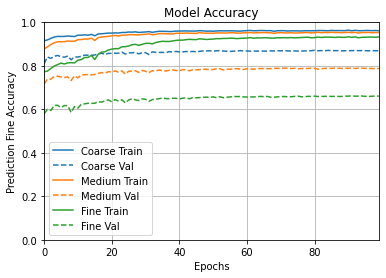

In [25]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

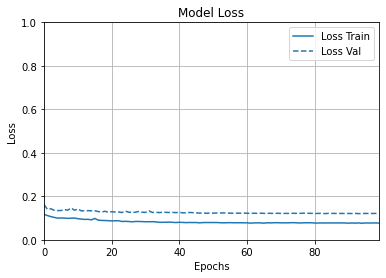

In [26]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [27]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 13s 33ms/step - loss: 0.1537 - prediction_coarse_loss: 0.0969 - prediction_medium_loss: 0.1606 - prediction_fine_loss: 0.2750 - prediction_coarse_accuracy: 0.8695 - prediction_medium_accuracy: 0.7876 - prediction_fine_accuracy: 0.6606
1. loss ==> 0.1536518633365631
2. prediction_coarse_loss ==> 0.09691981226205826
3. prediction_medium_loss ==> 0.160597562789917
4. prediction_fine_loss ==> 0.27500537037849426
5. prediction_coarse_accuracy ==> 0.8694999814033508
6. prediction_medium_accuracy ==> 0.7875999808311462
7. prediction_fine_accuracy ==> 0.6606000065803528
313/313 [==============================] - 9s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

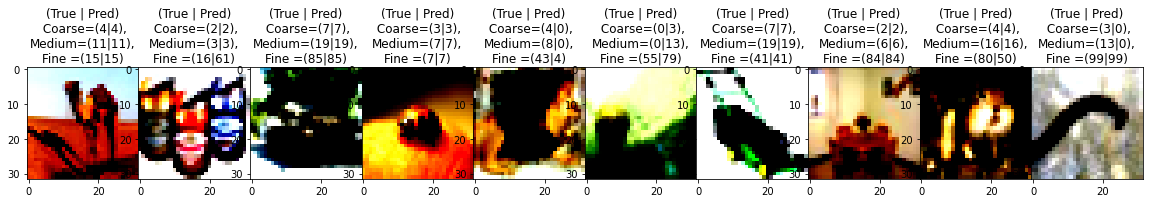

In [28]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 726   14   22   23  179   12   10   14]
 [  11 1366   28   33   36   21    2    3]
 [   7   28 1368   21   28   10   14   24]
 [  17   35   29  789  108    6    8    8]
 [  88   21   52   84 2222   10    9   14]
 [   7   25   28    4   31  880    0   25]
 [   4    8   13   12   26    1  434    2]
 [   9    1   30    5   20   25    0  910]]

  • MEDIUM LEVEL 
[[325  24   0   0   2   5   3   2  19   1   3  14  20  14   6  30  27   0
    2   3]
 [ 31 368   6   5   6   6   1   3   2   5   5   2   5   6   9  20  12   0
    4   4]
 [  1   5 447   3  15   3   3  15   0   1   1   0   0   2   1   2   0   1
    0   0]
 [  1   0   5 412  11  29   7   3   2   3   0   0   1   7   8   2   0   1
    2   6]
 [  0   3  18   7 427   7   0   6   6   1   0   2   3  11   1   3   2   2
    1   0]
 [  0   3   0  24   5 400  21   1   3   3   4   3   4   7   7   3   1   1
    5   5]
 [  1   3   1  14   3  19 429   2   1   5   2   0   3   2   5   1   1   1
    6   1]


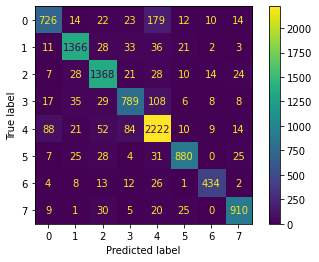

              precision    recall  f1-score   support

           0    0.83544   0.72600   0.77689      1000
           1    0.91188   0.91067   0.91127      1500
           2    0.87134   0.91200   0.89121      1500
           3    0.81256   0.78900   0.80061      1000
           4    0.83849   0.88880   0.86291      2500
           5    0.91192   0.88000   0.89567      1000
           6    0.90985   0.86800   0.88843       500
           7    0.91000   0.91000   0.91000      1000

    accuracy                        0.86950     10000
   macro avg    0.87519   0.86056   0.86712     10000
weighted avg    0.86959   0.86950   0.86884     10000


  • MEDIUM LEVEL 


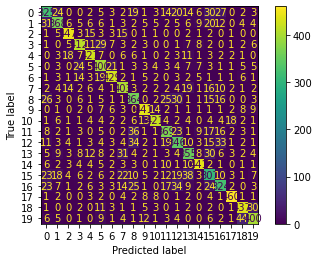

              precision    recall  f1-score   support

           0    0.68856   0.65000   0.66872       500
           1    0.78632   0.73600   0.76033       500
           2    0.87992   0.89400   0.88690       500
           3    0.81909   0.82400   0.82154       500
           4    0.83725   0.85400   0.84554       500
           5    0.73801   0.80000   0.76775       500
           6    0.87551   0.85800   0.86667       500
           7    0.76616   0.80600   0.78558       500
           8    0.69732   0.72800   0.71233       500
           9    0.86301   0.88200   0.87240       500
          10    0.89195   0.84200   0.86626       500
          11    0.75770   0.73800   0.74772       500
          12    0.68379   0.69200   0.68787       500
          13    0.70858   0.71000   0.70929       500
          14    0.87154   0.88200   0.87674       500
          15    0.60913   0.61400   0.61155       500
          16    0.69379   0.64800   0.67011       500
          17    0.91816   0

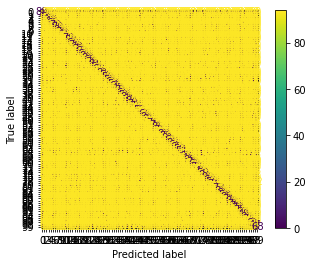

              precision    recall  f1-score   support

           0    0.85437   0.88000   0.86700       100
           1    0.77358   0.82000   0.79612       100
           2    0.54348   0.50000   0.52083       100
           3    0.54023   0.47000   0.50267       100
           4    0.47959   0.47000   0.47475       100
           5    0.67742   0.63000   0.65285       100
           6    0.76842   0.73000   0.74872       100
           7    0.67308   0.70000   0.68627       100
           8    0.85567   0.83000   0.84264       100
           9    0.79381   0.77000   0.78173       100
          10    0.54444   0.49000   0.51579       100
          11    0.46316   0.44000   0.45128       100
          12    0.72477   0.79000   0.75598       100
          13    0.62105   0.59000   0.60513       100
          14    0.66346   0.69000   0.67647       100
          15    0.58824   0.70000   0.63927       100
          16    0.66667   0.68000   0.67327       100
          17    0.78571   0

In [29]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [30]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.770745 
Hierarchical Recall = 0.7898666666666666 
Hierarchical F1-Score = 0.7782412698412697 
Consistency =  0.8885 
Exact Match =  0.6333
